# Table of contents
1. [Introduction](#introduction)
2. [Data Preparation](#Data-Preparation)
    1. [Numerical Fields](#Numerical-Fields)
    2. [Non-Numerical Fields](#Non-Numerical-Fields)
    3. [Missing Data](#Missing-Data)
    4. [Data Labels](#Data-Labels)
3. [Prediction Model](#Prediction-Model)
    1. [LightGBM + Optuna For Hyperparameters Optimization](#lgbm)
    2. [Stacking Models For Predictions](#stack)
    3. [Deep Learning Model](#DL)
4. [Conclusion](#Conclusion)

# Introduction <a name="introduction"></a>

<div class="alert alert-block alert-info">
    During this challenge, we are going to predict the final price of each house. We are given 2 data sets: train and test. Each data set contain many features that we will explore, try to find eventual correlations beween them and select the most useful ones to predict the house price.
    Finally, we will test and compare a few models trained on this data in order to select the model with the best performance.
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Data preparation <a name="Data-Preparation"></a>

<div class="alert alert-block alert-info">
    First, we import the training and testing data. We will be using pandas library to manipulate and display data.
</div>

In [2]:
# Import the training and testing data to explore them
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print("Training samples:", len(df_train))
print("Testing samples:", len(df_test))
df_train.head()

Training samples: 1200
Testing samples: 260


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<div class="alert alert-block alert-info">
This overview gave us  an idea about the data structure we will be using as well as the different fields of the data set. We notice that there are so many features in this data set. So in the first part we will choose the most useful features to keep.<br><br>
We start by dropping the 'Id' column which is totally useless for the prediction.
    </div>

In [3]:
# Drop Id and extract target
df_train_target = df_train['SalePrice']
df_test_target = df_test['SalePrice']
df_train = df_train.drop(['Id','SalePrice'], axis=1)
df_test = df_test.drop(['Id','SalePrice'], axis=1)

## Numrical Fields <a name="Numerical-Fields"></a>

<div class="alert alert-block alert-info">
    A quick discription of the numerical fields is quiet useful to have an idea about our data (e.g. the data range, min/max, mean of each column, etc).
    </div>

In [4]:
# Descriptive summary of numeric fields
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,45.260000,...,472.604167,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833
std,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,158.931453,...,212.722444,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,0.000000,...,478.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,...,1390.000000,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000


<div class="alert alert-block alert-info">
    The range of values of each column varies widely. So normalizing the data is an important step in order to avoid any scaling problem (e.g distances between points won't be dominated by features with high values) and also to speed up the training process (e.g. gradient descent will converge faster).
    </div>

In [5]:
c_ = df_train.describe().columns
df_train[c_] = (df_train[c_] - df_train[c_].mean()) / df_train[c_].std()
df_test[c_] = (df_test[c_] - df_test[c_].mean()) / df_test[c_].std()

### Correlation Matrix

<div class="alert alert-block alert-info">
    As we can see we have so many features describing the data samples. Probably not all of these feature are importatnt to predict our target which is the selling price ('SalePrice').<br><br>
    So now, we are going to keep only columns which are relevent to this problem. So let's have a quick look to the correlation between different features using the correlation matrix.
    </div>

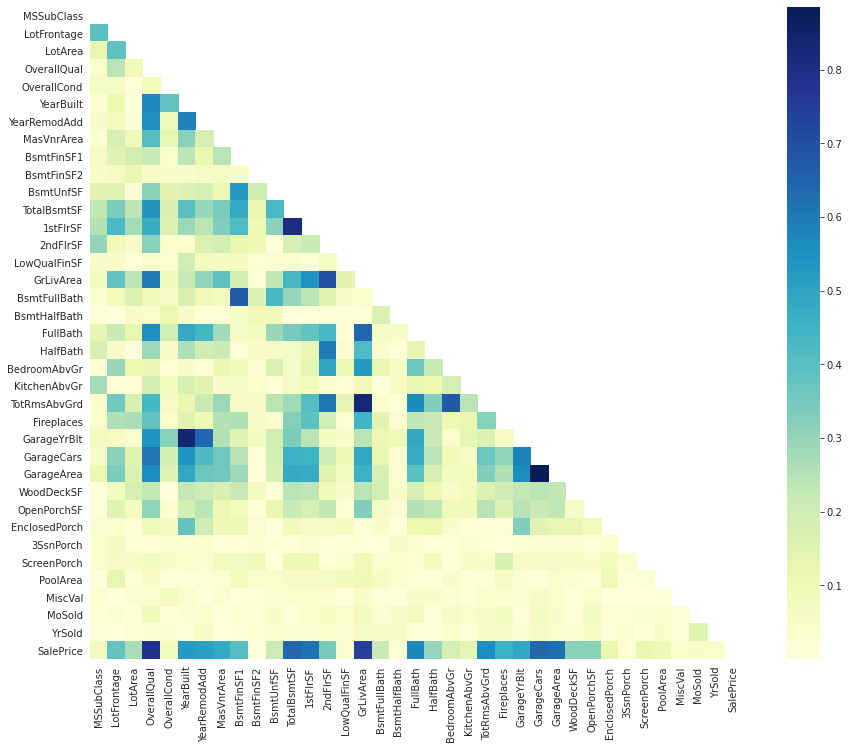

In [6]:
#correlation matrix
corrmat = np.abs(pd.concat([df_train, df_train_target], axis=1).corr())
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 12))
    ax = sns.heatmap(corrmat, mask=mask, square=True, cmap="YlGnBu")

<div class="alert alert-block alert-info">
    This heatmap gave us a great overview of our data as well as the relationship between different features.<br><br>
    We notice that there are many darkblue-colored squares: there are obvious correlations such as between the number of rooms at each level and the surface of that level (ground or higher floors), between surfaces of different levels, and also between surface and capacity of garages.<br><br>
    These columns give almost the same information, so we can get rit of extra ones.<br><br>
    We can also look to features that are directly correlated with the 'SalePrice': we get 'GrLivArea', 'TotalBsmtSF', and 'OverallQual'.
    </div>

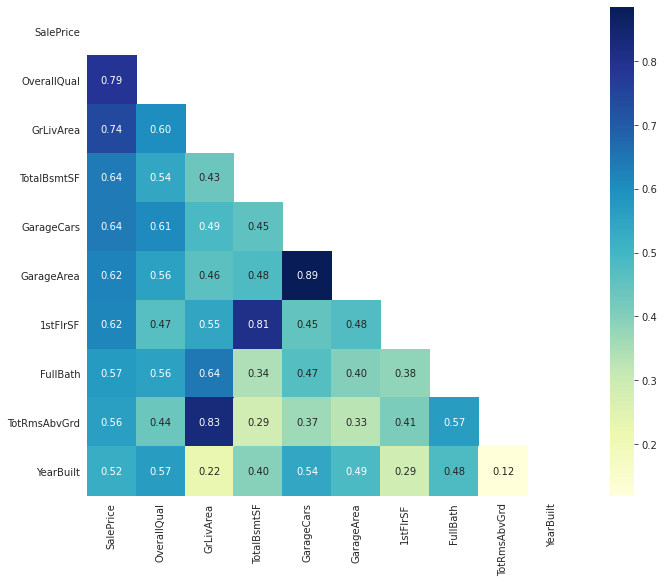

In [7]:
# SalePrice correlation matrix
n = 10
cols = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index # List of highly correlated colums with 'SalePrice'
cm = np.corrcoef(pd.concat([df_train, df_train_target], axis=1)[cols].values.T)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(cm)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 9))
    ax = sns.heatmap(cm, 
                     mask=mask, 
                     cbar=True, 
                     annot=True, 
                     square=True, 
                     fmt='.2f', 
                     annot_kws={'size': 10}, 
                     yticklabels=cols.values, 
                     xticklabels=cols.values,
                     cmap="YlGnBu")
    plt.show()

<div class="alert alert-block alert-info">
To sum up:
<li> 'GrLivArea', 'TotalBsmtSF' and 'OverallQual' are highly correlated with 'SalePrice'.
<li> '1stFlrSF' and 'TotalBsmtSF': the first floor square feet and the total square feet of basement area are obviously highly correlated. We can keep only 'TotalBsmtSF'.
<li> 'TotRmsAbvGrd' and 'GrLivArea': total rooms above grade and above grade living area square feet. 'GrLivArea' to be kept.
<li> 'YearBuilt' and 'GarageYrBlt': it's probably the same year of building the house and the garage. 'GarageYrBlt' to be dropped.
<li> 'GarageArea' and 'GarageCars': the surface of the garage and it's capacity are highly related (obvious).
    </div>

### Scatter Plot

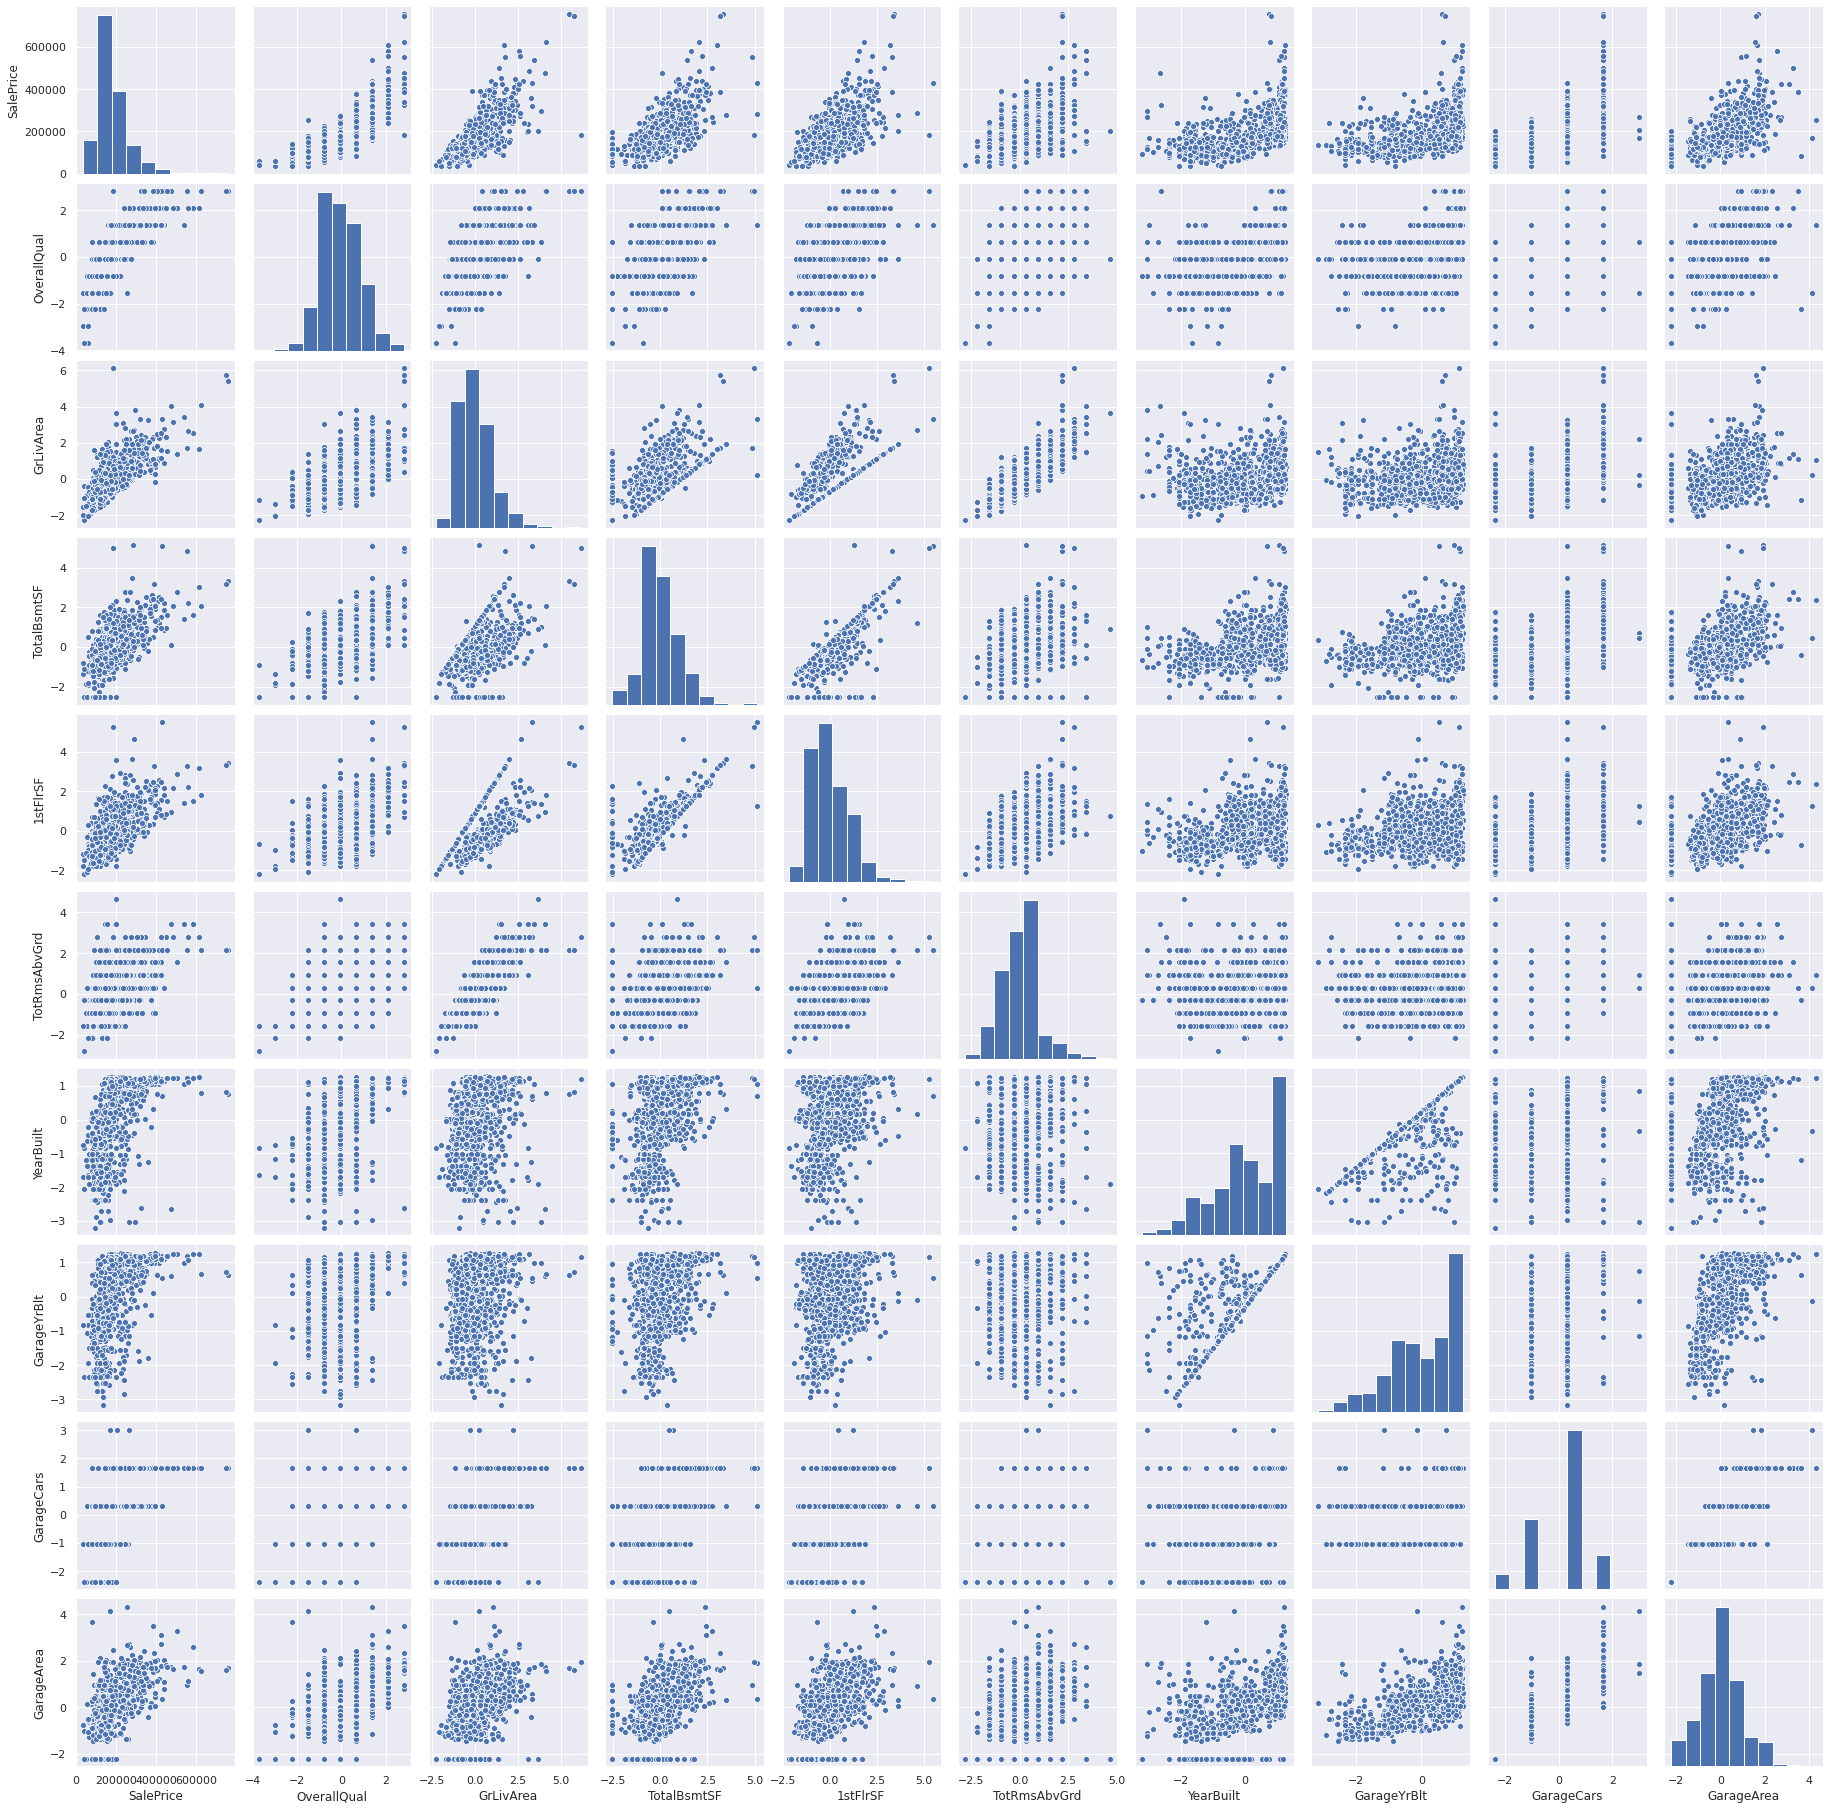

In [8]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'GarageYrBlt', 'GarageCars', 'GarageArea']
sns.pairplot(pd.concat([df_train, df_train_target], axis=1)[cols], size = 2.5)
plt.show();

<div class="alert alert-block alert-info">
    As previously discussed, the sale price is linearly correlated with the material rates, ground and basement surface.<br>

we can see an exponential relation between sale price and build year especially during the recent year.<br>

Garage build year and build year are related but not always equal.<br>

Garage capacity is a result of its area.
    </div>

In [9]:
# Numerical columns to keep
numerical_cols = ['GrLivArea',
                  'TotalBsmtSF',
                  'OverallQual',
                  'TotalBsmtSF',
                  'GrLivArea',
                  'YearBuilt',
                  'GarageArea',
                  'FullBath',
                  'MSSubClass',
                  'YearRemodAdd']

In [10]:
df_train_num = df_train[numerical_cols]
df_test_num = df_test[numerical_cols]
print("Training data:", df_train_num.shape)
print("Testing data:", df_test_num.shape)

Training data: (1200, 10)
Testing data: (260, 10)


In [11]:
df_num = pd.concat([df_train_num, df_test_num], ignore_index=True)

## Non-Numerical/Categorical Fields <a name="Non-Numerical-Fields"></a>

<div class="alert alert-block alert-info">
In this part, we will treat non-numerical feature.<br>

The first step is to find eventual correlations between these fields and if there are interesting relations with 'SalePrice' target.<br>

Then, we will convert them to numerical fields using the One-Hot-Encoding and the Label Encoding methods. This step is very important in order to be able to train our model later.<br>

Label Encoding will be used for fields with comparable values, e.g. 'GarageQual' whose values can be converted to 5, 4, 3, 2, 1 and 0 for Ex (Excellent), Gd (Good), TA (Typical/Average), Fa (Fair), Po (Poor) and NA (No Garage) respectively.<br>

One-Hot-Encoding will be used for other categorical fields whose values are not comparable, e.g. 'MSZoning' for zone classification. 
</div>

In [12]:
# Print fields' types
df_train.dtypes.unique()

array([dtype('float64'), dtype('O')], dtype=object)

In [13]:
# Extracting non-nemeric fields
df_train_non_num = df_train.select_dtypes(include=['O'])
df_train_non_num.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [14]:
df_train_non_num.nunique()

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        7
BldgType          5
HouseStyle        8
RoofStyle         5
RoofMatl          6
Exterior1st      14
Exterior2nd      15
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           4
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       3
SaleType          9
SaleCondition     6
dtype: int64

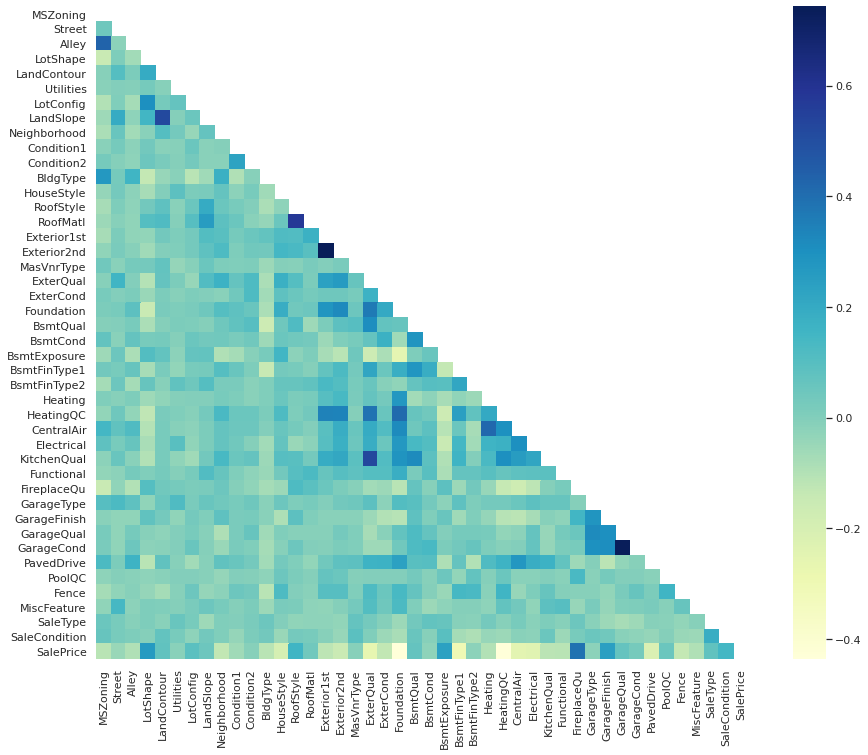

In [15]:
non_num_corr = pd.concat([df_train_non_num.apply(lambda x: x.factorize()[0]), df_train_target], axis=1).corr()
mask = np.zeros_like(non_num_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 12))
    ax = sns.heatmap(non_num_corr, mask=mask, square=True, cmap="YlGnBu")

In [16]:
# columns to convert to numerical values
label_encoding_cols = ['Utilities',
                'LandSlope',
                'ExterQual',
                'ExterCond',
                'BsmtQual',
                'BsmtCond',
                'BsmtExposure',
                'BsmtFinType1',
                'BsmtFinType2',
                'HeatingQC',
                'CentralAir',
                'KitchenQual',
                'Functional',
                'FireplaceQu',
                'GarageType',
                'GarageFinish',
                'GarageQual',
                'GarageCond',
                'PavedDrive',
                'PoolQC',
                'Fence']
one_hot_cols = ['MSZoning',
                       'Street',
                       'Alley',
                       'LotShape',
                       'LandContour',
                       'LotConfig',
                       'Neighborhood',
                       'Condition1',
                       'Condition2',
                       'BldgType',
                       'HouseStyle',
                       'RoofStyle',
                       'RoofMatl',
                       'Exterior1st',
                       'Exterior2nd',
                       'MasVnrType',
                       'Foundation',
                       'Heating',
                       'Electrical',
                       'MiscFeature',
                       'SaleType',
                       'SaleCondition']

In [17]:
all_data = pd.concat([df_train, df_test], ignore_index=True)
all_data.shape

(1460, 79)

In [18]:
# Convert categorical variable into indicator variables
df_cat_one_hot = pd.get_dummies(all_data[one_hot_cols], dummy_na=True, columns=one_hot_cols, drop_first=True)
df_cat_one_hot.shape

(1460, 162)

In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [20]:
df_label_encoding = pd.DataFrame(columns=label_encoding_cols)
for col in label_encoding_cols:
  labelencoder = LabelEncoder()
  df_label_encoding[col] = labelencoder.fit_transform(all_data[col].astype(str))
  # print(labelencoder.fit_transform(df_train[col].astype(str)))
df_label_encoding.head()

,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,0,0,2,4,2,3,3,2,5,0,...,2,6,5,1,1,4,4,2,3,4
1,0,0,3,4,2,3,1,0,5,0,...,3,6,4,1,1,4,4,2,3,4
2,0,0,2,4,2,3,2,2,5,0,...,2,6,4,1,1,4,4,2,3,4
3,0,0,3,4,3,1,3,0,5,2,...,2,6,2,5,2,4,4,2,3,4
4,0,0,2,4,2,3,0,2,5,0,...,2,6,4,1,1,4,4,2,3,4


## Missing Data <a name="Missing-Data"></a>

In [21]:
# Missing Data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1196,0.996667
MiscFeature,1153,0.960833
Alley,1125,0.937500
Fence,973,0.810833
FireplaceQu,564,0.470000
LotFrontage,210,0.175000
GarageType,67,0.055833
GarageFinish,67,0.055833
GarageQual,67,0.055833
GarageCond,67,0.055833


<div class="alert alert-block alert-info">
    After reading the full description of each column available in the description file, we make sure that 'NaN' values are not missing data, but usually refer to a missing feature in the house, e.g. a 'NaN' value in 'PoolQC' colums means "no pool in the house". This is the case for the 5 columns with the highest missing data percent (PoolQC, MiscFeature, Alley, Fence, FireplaceQu).<br>

So we will keep the missing values for these columns because they give us information about the house features.
    </div>

In [22]:
df_train['LotFrontage'].unique()

array([-2.14617436e-01,  4.18239777e-01, -8.80459934e-02, -4.25569840e-01,
        5.87001701e-01,  6.29192182e-01,  2.07287373e-01,             nan,
       -8.05284168e-01, -8.47474649e-01, -3.66503167e-03,  8.82335067e-01,
        8.07159301e-02, -1.72426955e-01,  1.30423988e+00, -5.52141283e-01,
       -1.10061753e+00,  1.68395420e+00,  1.17766843e+00, -9.74046092e-01,
        1.59957324e+00,  1.76833517e+00,  1.65096892e-01,  1.89490661e+00,
       -3.83379360e-01, -9.31855611e-01, -1.56471282e+00, -7.63093687e-01,
        1.26204939e+00, -1.94442715e+00,  7.97954105e-01, -2.98998398e-01,
        2.49477854e-01,  4.60430258e-01,  1.05109699e+00, -4.58555126e-02,
       -2.07099859e+00, -1.60690331e+00,  3.33858815e-01,  2.14804949e+00,
        2.19023997e+00, -1.26937946e+00,  1.47300180e+00,  1.22906411e-01,
        2.91668334e-01, -2.56807917e-01,  1.00890651e+00, -1.52252234e+00,
        8.40144586e-01, -6.36522245e-01,  7.55763624e-01,  5.02620739e-01,
        3.85254492e-02,  

<div class="alert alert-block alert-info">
    Regarding the 'LotFrontage' column, 'NaN' values are indeed missing data. Since missing data percent for this feature is quiet hight (about 17%), we can choose to drop this column or replace 'NaN' values with 0's.<br>

The missing data for Garage features won't affect our work (about 5% of missing data). But we can get rid of Garage and Basement features and only keep the surface because they are not relevent when buying a house.<br>

Finally, we can consider that the masonry veneer features are not essential and have no direct effect on the sale price ('MasVnrArea' is correlated with 'GrLivArea' and 'TotRmsAbvGrd' which are considered as main features).
    </div>

<div class="alert alert-block alert-info">
    We can now decide what features to keep and to delete:
<li> Bsmt features to delete: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, BsmtFullBath, BsmtHalfBath.
<li> Bsmt features to keep: TotalBsmtSF
<li> Garage features to delete: GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageQual, GarageCond
<li> Garage features to keep: GarageArea
<li> Masonry veneer features to delete: MasVnrArea, MasVnrType
<li> Masonry veneer features to keep: None
    </div>

In [23]:
# fianl df after selecting necessary features
df_final = pd.concat([df_num, df_cat_one_hot, df_label_encoding], axis=1)
df_final.shape

(1460, 193)

In [24]:
# Extract training and testing data
df_train = df_final.iloc[:1200]
df_test = df_final.iloc[1200:]

In [25]:
from scipy import stats
from sklearn import preprocessing

In [26]:
X_train, y_train = df_train.values, df_train_target.values
X_test, y_test = df_test.values, df_test_target.values

## Data Labels <a name="Data-Labels"></a>

<div class="alert alert-block alert-info">
Let's explore the target feature by calculating it's skewness and visualizing the distribution of data.
    </div>

Skewness: 1.967215


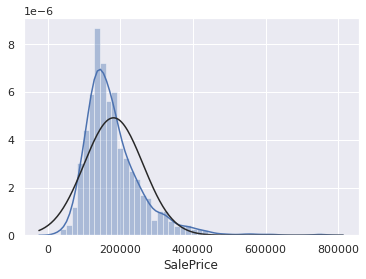

In [27]:
print("Skewness: %f" % df_train_target.skew())
sns.distplot(df_train_target, fit=stats.norm)

<div class="alert alert-block alert-info">
    Skewed data can reduce the performance of our predictive model. As a first step, we are going to apply the log transformation to the target field.
    </div>

Skewness: 0.132714


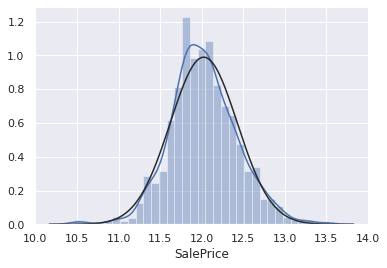

In [28]:
print("Skewness: %f" % np.log(df_train_target).skew())
sns.distplot(np.log(df_train_target), fit=stats.norm)

<div class="alert alert-block alert-info">
    The skew ceofficient went from 1.96 to 0.13 by applying the log transformation to the target field. As we can see in the last visualization, the data is now much closer to a normal distribution.<br>

When making predictions, we have to reverse the log transformation (i.e. apply exp transformation) in order to get the 'SalePrice'. Or we can choose to transform the target label of the testing data.
    </div>

<div class="alert alert-block alert-warning">
    Note: Some data preprocessing ideas were inspired from the House Pricing Kaggle Competition (https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python).
    </div>

In [29]:
#Applying log transformation
y_train = np.log(y_train)
y_test = np.log(y_test)

# Prediction Model <a name="Prediction-Model"></a>

In [30]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import tensorflow 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import optuna

<div class="alert alert-block alert-info">
    We use cross validation error to compare our models.
    </div>

In [31]:
# Define validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    score = np.mean(rmse)
    return(score)
  
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

<div class="alert alert-block alert-info">
    Train different simple models for later use.
</div>

In [32]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("Enet score is :", score)

Enet score is : 0.13682678960721764


In [33]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

score = rmsle_cv(KRR)
print("KRR score is :", score)

KRR score is : 0.13723828381390502


In [34]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score:", score)

Lasso score: 0.13675368241324085


## LightGBM + Optuna For Hyperparameters Optimization <a name="lgbm"></a>

<div class="alert alert-block alert-info">
Optuna is a library for bayesian hyper parameter optimisation.<br>

It seeks the directions (parameters) that have the biggest impact on the loss of our model and follows this direction for choosing the hyperparameter for the next round.<br>

Just give it the hyperparameters you want to update, how you want to sample from those (uniform / log uniform..) and an evaluation metric (score) and it will work on minimizing it for you.
    </div>

In [35]:
dtrain = lgb.Dataset(X_train,label=y_train)
dtest = lgb.Dataset(X_test,label=y_test)


def objective(trial):
 

    
    param = {
        #"objective": "regression",
        ## "verbosity": -1,
        #"device":"gpu",
        "boostingtype":"goss",
        "learning_rate":trial.suggest_loguniform("learning_rate",0.01,0.1),
        'subsample': trial.suggest_uniform("subsample",0.5,1),
        'feature_fraction':trial.suggest_uniform("subsample",0.5,1),
        "num_leaves": int(trial.suggest_discrete_uniform("num_leaves", 2, 10,1)),
        "n_estimators":int(trial.suggest_loguniform("n_estimators",300,1500)),
        "min_data_in_leaf": int(trial.suggest_loguniform("min_data_in_leaf",4,40)),
      
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "root_mean_squared_error")

    model = lgb.LGBMRegressor(**param)
    pipe = make_pipeline(RobustScaler(),model)
    
    score = rmsle_cv(pipe)
    print("Score is", score)
    return score
  


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=200), direction="minimize")
    
    study.optimize(objective, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    best_trial = study.best_trial

    print("  Value: {}".format(best_trial.value))

    print("  Params: ")
    for key, value in best_trial.params.items():
        print("    {}: {}".format(key, value))
    

Score is 0.13600313032409703


[I 2020-05-13 00:02:26,245] Finished trial#0 with value: 0.13600313032409703 with parameters: {'learning_rate': 0.01923119462002535, 'subsample': 0.6626468518675733, 'num_leaves': 9.0, 'n_estimators': 647.6352032192165, 'min_data_in_leaf': 21.033077119746185}. Best is trial#0 with value: 0.13600313032409703.


Score is 0.13640568127865232


[I 2020-05-13 00:02:27,995] Finished trial#1 with value: 0.13640568127865232 with parameters: {'learning_rate': 0.024613463875544094, 'subsample': 0.8507784648943293, 'num_leaves': 10.0, 'n_estimators': 493.03789482908246, 'min_data_in_leaf': 14.362849260435436}. Best is trial#0 with value: 0.13600313032409703.


Score is 0.1349189391273471


[I 2020-05-13 00:02:28,664] Finished trial#2 with value: 0.1349189391273471 with parameters: {'learning_rate': 0.059348839250226805, 'subsample': 0.9945366417050793, 'num_leaves': 3.0, 'n_estimators': 390.90546012907805, 'min_data_in_leaf': 9.898292162804019}. Best is trial#2 with value: 0.1349189391273471.


Score is 0.13871747406835083


[I 2020-05-13 00:02:30,442] Finished trial#3 with value: 0.13871747406835083 with parameters: {'learning_rate': 0.069324825051667, 'subsample': 0.7523892885875515, 'num_leaves': 7.0, 'n_estimators': 1014.0907893209081, 'min_data_in_leaf': 8.00434817044987}. Best is trial#2 with value: 0.1349189391273471.


Score is 0.138256553664015


[I 2020-05-13 00:02:31,248] Finished trial#4 with value: 0.138256553664015 with parameters: {'learning_rate': 0.018382734588964663, 'subsample': 0.7498495471593678, 'num_leaves': 4.0, 'n_estimators': 414.69291940907084, 'min_data_in_leaf': 6.168345054282901}. Best is trial#2 with value: 0.1349189391273471.


Score is 0.14428494968450611


[I 2020-05-13 00:02:31,859] Finished trial#5 with value: 0.14428494968450611 with parameters: {'learning_rate': 0.056910426348052066, 'subsample': 0.8949690215207301, 'num_leaves': 2.0, 'n_estimators': 455.8345176759971, 'min_data_in_leaf': 38.51505322114788}. Best is trial#2 with value: 0.1349189391273471.


Score is 0.13541023518338582


[I 2020-05-13 00:02:33,110] Finished trial#6 with value: 0.13541023518338582 with parameters: {'learning_rate': 0.010969369772362703, 'subsample': 0.6904482246527368, 'num_leaves': 4.0, 'n_estimators': 960.8874925988346, 'min_data_in_leaf': 19.22499177034413}. Best is trial#2 with value: 0.1349189391273471.


Score is 0.13210578425376807


[I 2020-05-13 00:02:34,644] Finished trial#7 with value: 0.13210578425376807 with parameters: {'learning_rate': 0.02184369730127071, 'subsample': 0.5128444945002342, 'num_leaves': 5.0, 'n_estimators': 1187.1548228495471, 'min_data_in_leaf': 15.979845843774275}. Best is trial#7 with value: 0.13210578425376807.


Score is 0.1682655819291983


[I 2020-05-13 00:02:35,218] Finished trial#8 with value: 0.1682655819291983 with parameters: {'learning_rate': 0.017935162873548946, 'subsample': 0.5229929455018336, 'num_leaves': 2.0, 'n_estimators': 357.96774663786687, 'min_data_in_leaf': 13.255524740231005}. Best is trial#7 with value: 0.13210578425376807.


Score is 0.1362679938439728


[I 2020-05-13 00:02:36,435] Finished trial#9 with value: 0.1362679938439728 with parameters: {'learning_rate': 0.016582307774637164, 'subsample': 0.8659955203836165, 'num_leaves': 3.0, 'n_estimators': 1017.6045021394999, 'min_data_in_leaf': 5.488615281157206}. Best is trial#7 with value: 0.13210578425376807.


Number of finished trials: 10
Best trial:
  Value: 0.13210578425376807
  Params: 
    learning_rate: 0.02184369730127071
    subsample: 0.5128444945002342
    num_leaves: 5.0
    n_estimators: 1187.1548228495471
    min_data_in_leaf: 15.979845843774275


In [36]:
params = {}
for key, value in best_trial.params.items():
  if value > 1:
    params[key] = int(value)
  else :
    params[key] = value

## Little trick to have better accuracy : Divide the learning rate and double the number of learners by same constant (doesn't work here :'( )

params["learning_rate"] *= 0.5
params["n_estimators"] *= 2

GBM = make_pipeline(RobustScaler(), lgb.LGBMRegressor(**params))
rmsle_cv(GBM)


0.13391835487283882

## Stacking Models For Predictions <a name="stack"></a>

<div class="alert alert-block alert-info">
    In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.<br>

The procedure, for the training part, may be described as follows:<br>
    <ul>
    <li>Split the total training set into two disjoint sets (here train and .holdout)</li>
    <li>Train several base models on the first part (train)</li>
    <li>Test these base models on the second part (holdout)</li>
    </ul>

Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.
</div>

In [37]:
class MetaModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
 
        #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

In [38]:
meta = MetaModel(base_models = (ENet, GBM, KRR), meta_model = lasso)

score = rmsle_cv(meta)
print("Score is ", score)

Score is  0.13132544460806347


In [39]:
meta.fit(X_train, y_train)
meta.base_models_
pred = meta.predict(X_test)
rmsle(pred, y_test)

0.15162988008351325

## Deep Learning Model <a name="DL"></a>

<div class="alert alert-block alert-info">
While implementing this modele we use some experimental features from Tensorflow Addons, tensorflow's library for the latest research results.

For this model we used the NovoGrad Optimizer which usesgradient descent method with layer-wise gradient normalization and decoupled weight decay adapted [from this paper](https://arxiv.org/abs/1905.11286).

We wrap the optimizer in the [lookahead wrapper](https://arxiv.org/abs/1907.08610),  the algorithm chooses a search direction by looking ahead at the sequence of K fast weights generated by another optimizer.

We use an exponentially decreasing [cyclical learning rate scheduler](https://arxiv.org/abs/1506.01186) . Instead of monotonically decreasing the learning rate, this method lets the learning rate cyclically vary between reasonable boundary values.

We train the model using leaky ReLU activation and minimal dropout at the beginning of the net. Batchnormalisation to make loss function smoother.
We also use early stopping with a patience of 200 epochs as we suppose that the model generalizes better at earlier stages of training as it didn't overfit training set yet.

All these addons allow us to train a decent DNN with minimal hyperparameter tuning especially for learning rate.
</div>

In [40]:
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dropout , BatchNormalization 
from tensorflow.nn import leaky_relu
from tensorflow.keras import backend as K
from tensorflow_addons.optimizers.novograd import NovoGrad

N_cols= 193
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
dict_keys(['loss', 'val_loss'])


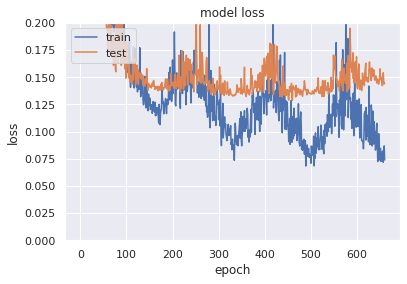

In [41]:
model = Sequential()
n_cols = X_train.shape[1]
print("N_cols=",n_cols)

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
def LR(x):
    return leaky_relu(x, alpha=0.1)

model.add(Dense(600, activation=LR, input_shape= (n_cols,)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(400, activation=LR))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(300, activation=LR))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(300, activation=LR))
model.add(BatchNormalization())
model.add(Dense(200, activation=LR))
model.add(BatchNormalization())
model.add(Dense(150, activation=LR))
model.add(BatchNormalization())
model.add(Dense(1))

# Learning rate :

lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
            initial_learning_rate=1e-4,
            maximal_learning_rate=1e-2,
            step_size=2000,
            scale_mode="cycle",
            gamma=0.96,
            name="MyCyclicScheduler")

# Optimizer

opt = NovoGrad(learning_rate=lr_schedule)
opt = tfa.optimizers.Lookahead(opt) ##WRAP OPTIMIZER WITH LookAhead layer 
##Early stopping
es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=200)

model.compile(optimizer=opt, loss=rmse)

# train model
history = model.fit(X_train, y_train, verbose=0, batch_size=40, validation_split=0.2, epochs=1000, callbacks=[es])

# list all data in history
print(history.history.keys())

# summarize history for loss
plt.ylim([0,0.2])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
y_pred = model.predict(X_test)
rmsle(y_pred, y_test)

0.13674783660080644

# Conclusion <a name="Conclusion"></a>

<div class="alert alert-block alert-info">
For model choice we finally choose the DNN as it performs better on our Test dataset.

We conclude that a good DNN can beat a fine tuned MetaModel on this task.

DNN can deal better with categorical data with low cardinality than any other simple model.

In contrast to LGBM it can map complex interactions between features. 
</div>